# Student: Rafael Santos
## Homework 10 - Data Analytics and Visualization - cohort 3

In [83]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [84]:
import numpy as np
import pandas as pd

In [85]:
import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

###  Use SQLAlchemy create_engine to connect to your sqlite database.

In [87]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

### Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.

In [88]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [89]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [90]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [91]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [92]:
#Verifing what columns and data look like in the table

temp = session.query(Measurement).first()
temp.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x99459b0>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [113]:
#First, manually checking the latest date available in the Measureament table

LatestDateTempMeasured = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
LatestDateTempMeasured =str(LatestDateTempMeasured[0])
LatestDateTempMeasured

'2017-08-23'

In [114]:
# Calculate the date 1 year ago from the last data point in the database

OneYearFromLastDataPoint = dt.datetime.strptime(LatestDateTempMeasured,'%Y-%m-%d') - dt.timedelta(days=365)
print(OneYearFromLastDataPoint)

2016-08-23 00:00:00


### Select only the date and prcp values.
### Load the query results into a Pandas DataFrame and set the index to the date column.
### Sort the DataFrame values by date.

In [115]:
temp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= OneYearFromLastDataPoint)\
                                                                .order_by(Measurement.date.asc()).all()

Prep_df = pd.DataFrame(temp)
Prep_df.set_index('date',inplace= True)
Prep_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


### Plot the results using the DataFrame plot method.

<function matplotlib.pyplot.show(*args, **kw)>

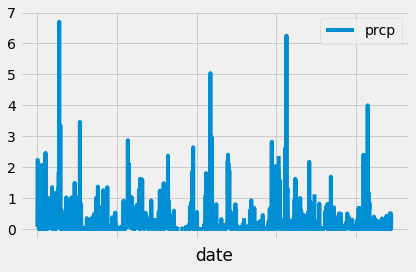

In [116]:
Prep_df.plot()
plt.tight_layout()
plt.show

### Use Pandas to calculate the summary statistics for the precipitation data

In [117]:
Prep_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [118]:
#Verifing what columns and data look like in the table

temp = session.query(Station).first()
temp.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xb3a36d8>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

### Design a query to calculate the total number of stations.

In [119]:
print(f'Total number of stations is {session.query(Station.station).count()}')

Total number of stations is 9


### Design a query to find the most active stations.
#### List the stations and observation counts in descending order.
#### Which station has the highest number of observations?

In [120]:
session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).filter(Measurement.station == Station.station).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [121]:
StationMostObservations=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station)\
                .order_by(func.count(Measurement.tobs).desc()).filter(Measurement.station == Station.station).first()
print(f'The station with the highest number of observations is {StationMostObservations[0]}')

The station with the highest number of observations is USC00519281


### Design a query to retrieve the last 12 months of temperature observation data (tobs).
#### Filter by the station with the highest number of observations.

In [122]:
StationMostObservedName = StationMostObservations[0]

tobs_12mo_query = session.query(Measurement.date,Measurement.tobs)\
                                                .filter(Measurement.station == str(StationMostObservedName))\
                                                .filter(Measurement.date >= '2016-08-22').all()

stationMaxObs_df = pd.DataFrame(tobs_12mo_query)
stationMaxObs_df.head()

,date,tobs
0,2016-08-22,78.0
1,2016-08-23,77.0
2,2016-08-24,77.0
3,2016-08-25,80.0
4,2016-08-26,80.0


### Plot the results as a histogram with bins=12.

<function matplotlib.pyplot.show(*args, **kw)>

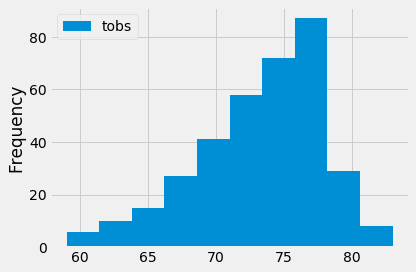

In [123]:
x = stationMaxObs_df['tobs']
bins = 12

stationMaxObs_df.plot.hist()

plt.plot(bins=12)
plt.tight_layout()
plt.show


## Step 2 - Climate App


### Design a Flask API based on the queries that you have just developed.

#### Use FLASK to create your routes.

In [124]:
## This FLASK code is on the app.py file in the same folder where this notebook is stored.

from flask import Flask, jsonify
# Adding this - DL
from sqlalchemy.orm import scoped_session, sessionmaker

app = Flask(__name__)



#################################################
# Database Setup
#################################################
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Adding this - DL
db_session = scoped_session(sessionmaker(autocommit=False,
                                         autoflush=False,
                                         bind=engine))

# Create our session (link) from Python to the DB
session = Session(engine)

#### Routes

In [125]:
#################################################
# Flask Routes
#################################################

# /
# Home page.
# List all routes that are available.

@app.route("/")
def Home():
    """List of all available api routes."""
    
    return (
        f"Welcome to Homework 10 API! - by Rafael Santos<br/><br/>"
        f"Available Routes:<br/><br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start_date><br/>"
        f"/api/v1.0/<start_date>/<end_date><br/>"
    )


          
# /api/v1.0/precipitation
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of your dictionary.          
          
@app.route("/api/v1.0/precipitation")
def YearPrec():
    
    temp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-22')\
                                                              .order_by(Measurement.date.asc()).all()

    date =[]
    precipitation=[]
    precipitation_dict ={}
    for date1, prcp1 in temp:
        date.append(date1)
        precipitation.append(prcp1)
    
    precipitation_dict = {date:precipitation for date,prcp in zip(date, precipitation)}


    return jsonify(precipitation_dict)


# /api/v1.0/stations
# Return a JSON list of stations from the dataset.
          
@app.route("/api/v1.0/stations")
def Stations():
    
    station_list_query = session.query(Station.station).all()
    station_list=[]
    
    for station1 in station_list_query:
          station_list.append(station1)
    
    return jsonify(station_list)
          

# /api/v1.0/tobs
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.
          
@app.route("/api/v1.0/tobs")
def TempLastYear():
    
    LastYearTemp_query = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > '2017-08-22').all()
    LastYearTemp_list=[]
    
    for tobs1 in LastYearTemp_query:
          LastYearTemp_list.append(tobs1)
          
    
    return jsonify(LastYearTemp_list)



# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a JSON list of the minimum temperature, the average temperature, 
## and the max temperature for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between 
## the start and end date inclusive.
          
@app.route("/api/v1.0/<start_date>")

def TempStats(start_date):
        
    
    TempStats_query = session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.date > start_date)\
    .all()

    Tmin = []
    Tavg=[]
    Tmax=[]
    TempStats_=[]
    
    for TempMin1,TempMax1,TempAvg1 in TempStats_query:
        Tmin.append(TempMin1)
        Tavg.append(TempAvg1)
        Tmax.append(TempMax1)
    
    TempStats_ = [Tmin,Tavg,Tmax]
           
    return jsonify(TempStats_)


@app.route("/api/v1.0/<start_date>/<end_date>")

def TempStats2(start_date,end_date):

    TempStats_query = session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.date > start_date)\
    .filter(Measurement.date < end_date)\
    .all()

    Tmin = []
    Tavg=[]
    Tmax=[]
    TempStats_=[]
    
    for TempMin1,TempMax1,TempAvg1 in TempStats_query:
        Tmin.append(TempMin1)
        Tavg.append(TempAvg1)
        Tmax.append(TempMax1)
    
    TempStats_ = [Tmin,Tavg,Tmax]
           
    return jsonify(TempStats_)


          
# Adding this - DL
@app.teardown_appcontext
def cleanup(resp_or_exc):
    print('Teardown received')
    db_session.remove()

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\BahMN\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Optional: Other Recommended Analyses

In [126]:
#The following are optional challenge queries. 
#These are highly recommended to attempt, but not required for the homework.

## Temperature Analysis

In [127]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [141]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

##MyTripDate = '2017-01-01'
##OneYearBeforeMyTrip = '2016-01-01'

calc_temps('2016-01-01','2017-01-01')

[(56.0, 74.1317494600432, 84.0)]

<function matplotlib.pyplot.show(*args, **kw)>

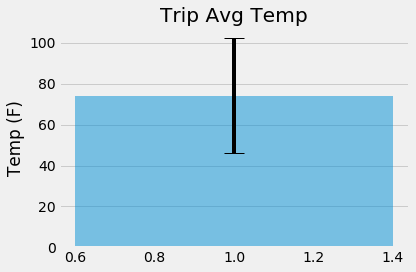

In [154]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
bonuslist = calc_temps('2016-01-01','2017-01-01')
for x1,y1,z1 in bonuslist:
    x = x1
    y = y1
    z = z1
    
fig, ax = plt.subplots()
ax.bar(1, y, yerr=z-x, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.xaxis.grid(False)

plt.tight_layout()
plt.show

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Daily Rainfall Average

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
